# Aula 4

# Soluções Numéricas

Frequentemente, em situações reais, os problemas de engenharia são muito complexos para que uma solução analítica (uma equação explícita). Nesses casos geralmente utilizamos soluções numéricas. De forma geral essas soluções consistem em dividir um problema real em pequenas partes (discretização) e aplicar os princípios físicos que regem o problema às essas pequenas partes. Nessa aula construiremos soluções numéricas para problemas de magnetismo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mi0 = 4*np.pi*1e-7 #[H/m]

Trataremos do problema de um dipolo magnético, conforme a seção 8.4 do livro Física Básica - Eletromagnetismo de Alaor Chaves. Esse problema consiste no cálculo do campo magnético ao longo do eixo Z gerado por uma espira de raio $R$ onde circula uma corrente $I$, conforme figura abaixo:

<img src="problema_aula_4.png" alt="drawing" style="width: 25%;"/>

Para esse caso específico, uma solução analítica é possível e é dada por:



\begin{equation}
B = \frac{\mu_0}{2} \frac{IR^2}{(R^2+z^2)^{3/2}} 
\end{equation}

Que podemos implementar em Python facilmente:

In [2]:
def CalcularB(I, R, z):
    return (mi0*I*np.power(R,2))/(2.0*np.power(np.power(R, 2.0) + np.power(z, 2.0),3.0/2.0))

E podemos testá-la com valores arbitrários

In [3]:
R = 5 # [m] Raio da espira condutora
I = 1 # [A] corrente que circula na espira
z_pos = 1 # [m] posicao em Z para o qual o valor de campo magnetico sera calculado

CalcularB(I,R,z_pos)

1.1848404026933503e-07

Lembrando que o valor que essa função retorna é referente a componente ao longo do eixo Z. AS componentes $î$ e $ĵ$ são nulas.

Para desenvolver um método numérico que resolve o mesmo tipo de problema, precisamos primeiramente discretizar o sistema físico. Começaremos representando o círculo por um conjunto de pontos igualmente espaçados ao longo de seu perímetro.

In [4]:
num_pts = 30 # numero de pontos para discretizacao da espira
circle = np.zeros((num_pts,3)) # matriz de coordenadas x,y,z dos pontos que representam a espira
angles = np.linspace(start=0, stop=2*np.pi, num=num_pts) # os angulos para os quais calcularemos os pontos

for idx, angle in enumerate(angles):
    circle[idx,0] = R*np.cos(angle)
    circle[idx,1] = R*np.sin(angle)
    

No código acima nos criamos uma matriz nula de tamanho $num\_pts\times 3$. Em seguida é gerada uma lista de ângulos para os quais queremos calcular a posição $(x,y)$ do cículo, que correspondem às colunas 0 e 1, respectivamente. Para isso utilizamos as seguintes equações: 

\begin{equation}
    x = R cos(\theta)\\
    y = R sin(\theta)\\
    z = 0
\end{equation}

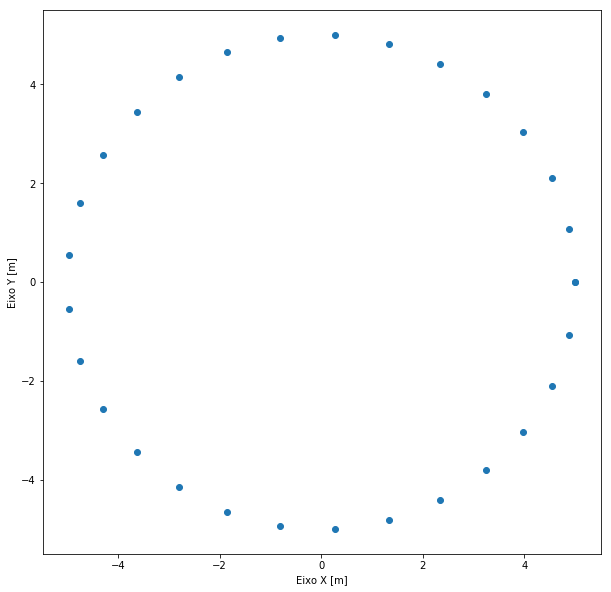

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(circle[:,0], circle[:,1]) # Plot do tipo scatter para visualisarmos os pontos 
plt.xlabel('Eixo X [m]')
plt.ylabel('Eixo Y [m]')
plt.show()

Com essa estrutura já podemos, por exemplo, calcular o perímetro da espira numericamente. Nesse caso devemos implementar a seguinte integral:

\begin{equation}
        P = \int_{C}|d\overrightarrow{L}|
\end{equation}

No domínio discreto, a integral acima vira um simples somatório:

\begin{equation}
        P = \sum_{n=1}^{k-1} |c[n+1]-c[n]|
\end{equation}

Onde $c[n]$ é o ponto na n-ésima linha da matriz de pontos do círculo, $k$ é o número de pontos utilizados para a discretização e $c[n+1]-c[n]$ é a aproximação discreta para  $d\overrightarrow{L}$.

In [6]:
perimeter = 0 # Acumulador para o perimetro
dL = np.zeros(circle.shape) # guardaremos os dLs para uso futuro
for idx in range(num_pts-1):
    dl = circle[idx+1,:] - circle[idx,:]
    dL[idx,:] = dl # armazena na matriz de dLs
    perimeter = perimeter + np.linalg.norm(dl) # acumula a norma de dl
print("O perimetro calculado eh %.7f e o valor teorico eh de %.7f " % (perimeter, 2*np.pi*R))    
    

O perimetro calculado eh 31.3545153 e o valor teorico eh de 31.4159265 


Lembrando que quanto maior o número de pontos utilizados na discretização, melhor será a aproximação. Altere a variável $num\_pts$ e veja o impacto no valor da aproximação.

Agora que temos os pontos da espira e uma matriz com todos os $dL$s que precisamos, conforme figura abaixo, podemos voltar ao problema inicial.

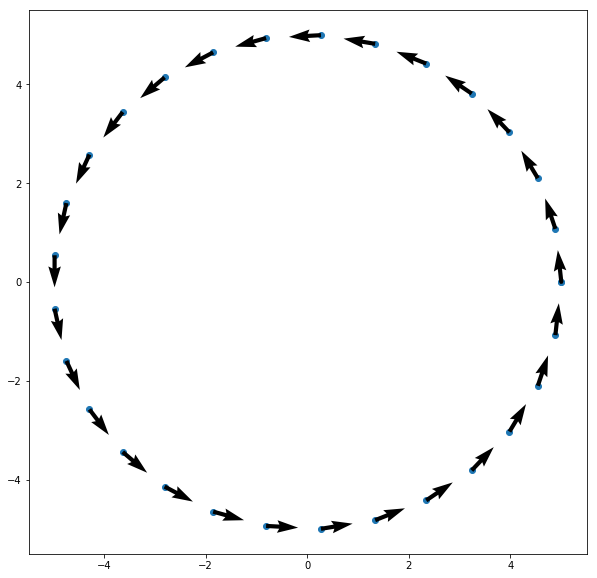

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(circle[:,0], circle[:,1])
plt.quiver(circle[:,0], circle[:,1], dL[:,0], dL[:,1],units='inches')
plt.show()


A integral que deve ser resolvida é:

\begin{equation}
    \overrightarrow{B} = \frac{\mu_0 I}{4\pi} \int \frac{d\overrightarrow{L} \times \overrightarrow{r}}{|\overrightarrow{r}|^3}
\end{equation}

In [8]:
B_resultante = np.zeros((1,3))
z_vector = np.array([0,0,z_pos])
K = (mi0/(4*np.pi))*I # Representamos todos os termos constantes apenas por K para facilidade

for c, dL_vec in zip(circle, dL): # Loop para percorrer pontos e seus dLs associados
    r_vec = z_vector - c
    dem = np.linalg.norm(r_vec)**3.0
    B_resultante = B_resultante + np.cross(dL_vec, r_vec)/dem

B_resultante = B_resultante*K
valor_analitico = CalcularB(I,R,z_pos)
print ("O valor teorico do campo na direcao Z eh %.5E e o valor calculado numericamente eh %.5E" % (valor_analitico, B_resultante[0,2]))
print ("O erro da aproximacao numerica eh %f%%" % ((valor_analitico - B_resultante[0,2])*100/valor_analitico))

O valor teorico do campo na direcao Z eh 1.18484E-07 e o valor calculado numericamente eh 1.17559E-07
O erro da aproximacao numerica eh 0.780536%


Utilizando a solução numérica temos acesso ainda a todas as componentes de $\overrightarrow{B}$:

In [9]:
print(B_resultante)

[[-3.46944695e-25 -1.01915004e-24  1.17559229e-07]]


Pode-se notar que as componentes X e Y não são exatamente 0, porém muito próximos, por conta da precisão da simulação. Novamente, quanto mais pontos forem utilizados, mais precisa é a simulação numérica.

## Exercício 1

Refazer a simulação substituindo o círculo de raio $R$ por um quadrado de lado $L=1m$ centrado na origem, mantendo o cálculo do campo no mesmo ponto. 

Dica: basta gerar a lista de pontos que representa o quadrado, o restante do problema é identico ao problema do círculo.

## Exercício 2


Dada a simulação do Ex. 1, agora calcular o módulo do campo magnético $\overrightarrow{B}$ ao longo de uma reta que passa pelo ponto $(0,0,0.1)$ e tem direção $î$ e plotar o resultado no intervalo de $-2 m$ à $2 m$.

Dica: Você terá que dividir a reta em diversos pontos e calcular o campo em cada um deles. 